Resources:

https://iamrajatroy.medium.com/document-intelligence-series-part-1-table-detection-with-yolo-1fa0a198fd7

https://huggingface.co/foduucom/table-detection-and-extraction

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Using_Table_Transformer_for_table_detection_and_table_structure_recognition.ipynb

In [ ]:
# Install Packages
!pip install ultralyticsplus==0.0.28 ultralytics==8.0.43 pdf2image matplotlib
!apt-get install -y poppler-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.6/299.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 15.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=75fcf840c4e4b77e6307499583577622ca0c61cab39eb06923092681b0607808
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from pdf2image import convert_from_path
from google.colab import files
from ultralyticsplus import YOLO
from transformers import DetrImageProcessor, TableTransformerForObjectDetection


In [ ]:
# Set display options for pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:

# Define colors in the 0-255 range for bounding box visualization
COLORS = [(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in
          [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098],
           [0.929, 0.694, 0.125], [0.494, 0.184, 0.556],
           [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]]

# Function to visualise the bounding boxes and labels on an image with table structure
def render_structure_on_image_with_labels(pil_img, scores, labels, boxes, color_map=COLORS):
    img_copy = pil_img.convert("RGB")
    draw = ImageDraw.Draw(img_copy)

    # Load default or Arial font for text rendering
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    # Draw bounding boxes with labels and scores on the image
    for score, label, (xmin, ymin, xmax, ymax), color in zip(scores.tolist(), labels.tolist(), boxes.tolist(), color_map * 100):
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)

        # Display label with score
        text = f"{model.config.id2label[label]}: {score:.2f}"
        text_bbox = draw.textbbox((xmin, ymin), text, font=font)
        draw.rectangle([xmin, ymin - text_bbox[3] + text_bbox[1], xmin + text_bbox[2] - text_bbox[0], ymin], fill="black")
        draw.text((xmin, max(0, ymin - (text_bbox[3] - text_bbox[1]))), text, fill="white", font=font)

    # Display the image with annotations
    print("Displaying table structure with enhanced bounding boxes and labels")
    display(img_copy)


In [ ]:
# Upload a PDF file
uploaded = files.upload()
pdf_file = next(iter(uploaded.keys()))  # Get the PDF filename

Saving eu-009a.pdf to eu-009a.pdf


In [ ]:
# Convert the PDF to images (use the first page)
pages = convert_from_path(pdf_file, dpi=300)
img = pages[0]  # Select the first page as an image


In [ ]:
# Load YOLO model for table detection
yolo_model = YOLO('keremberke/yolov8m-table-extraction')
yolo_model.overrides['conf'] = 0.25  # NMS confidence threshold
yolo_model.overrides['iou'] = 0.45  # NMS IoU threshold
yolo_model.overrides['agnostic_nms'] = False  # NMS class-agnostic
yolo_model.overrides['max_det'] = 1000  # Maximum detections per image


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:340: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


In [ ]:
# Perform YOLO inference
yolo_results = yolo_model.predict(img)

Ultralytics YOLOv8.0.43 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs

0: 640x480 1 bordered, 28.6ms
Speed: 0.5ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


YOLO Detected Boxes: tensor([[5.59000e+02, 1.32200e+03, 1.95900e+03, 2.28500e+03, 7.39909e-01, 0.00000e+00]], device='cuda:0')


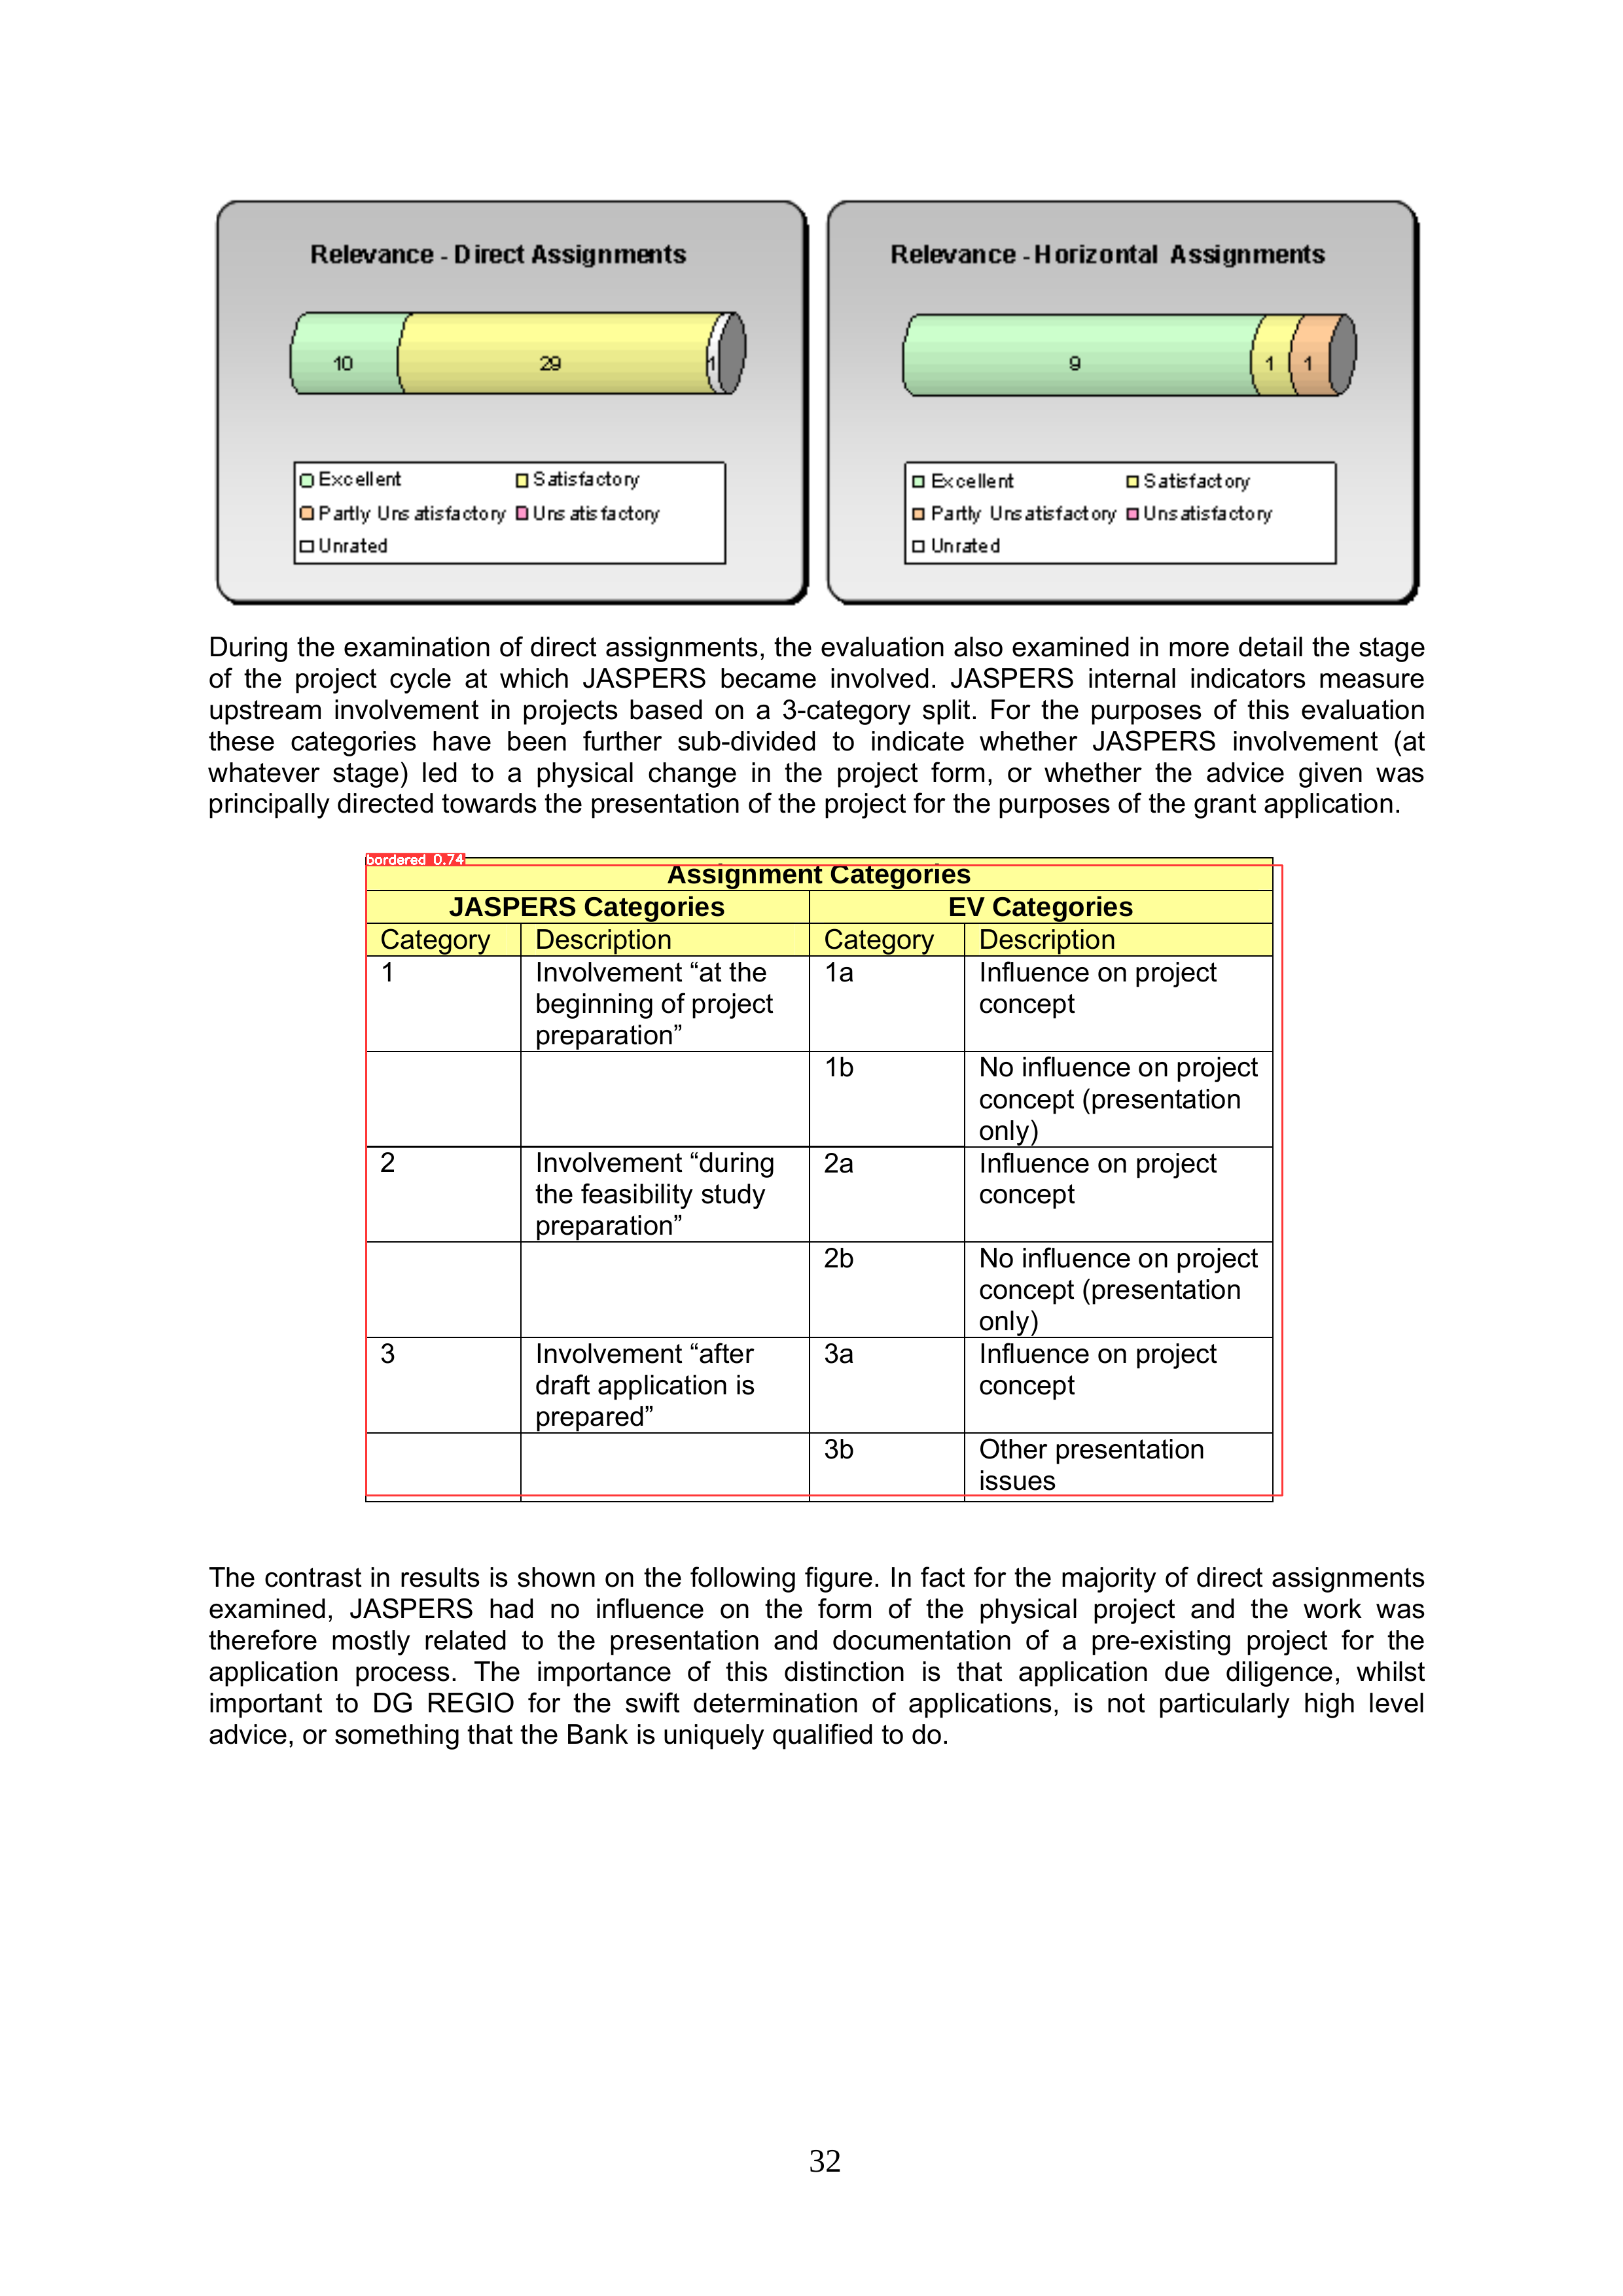

In [ ]:
# Render and display YOLO results
print('YOLO Detected Boxes:', yolo_results[0].boxes)
yolo_render = render_result(model=yolo_model, image=img, result=yolo_results[0])
yolo_render


Displaying cropped table 1


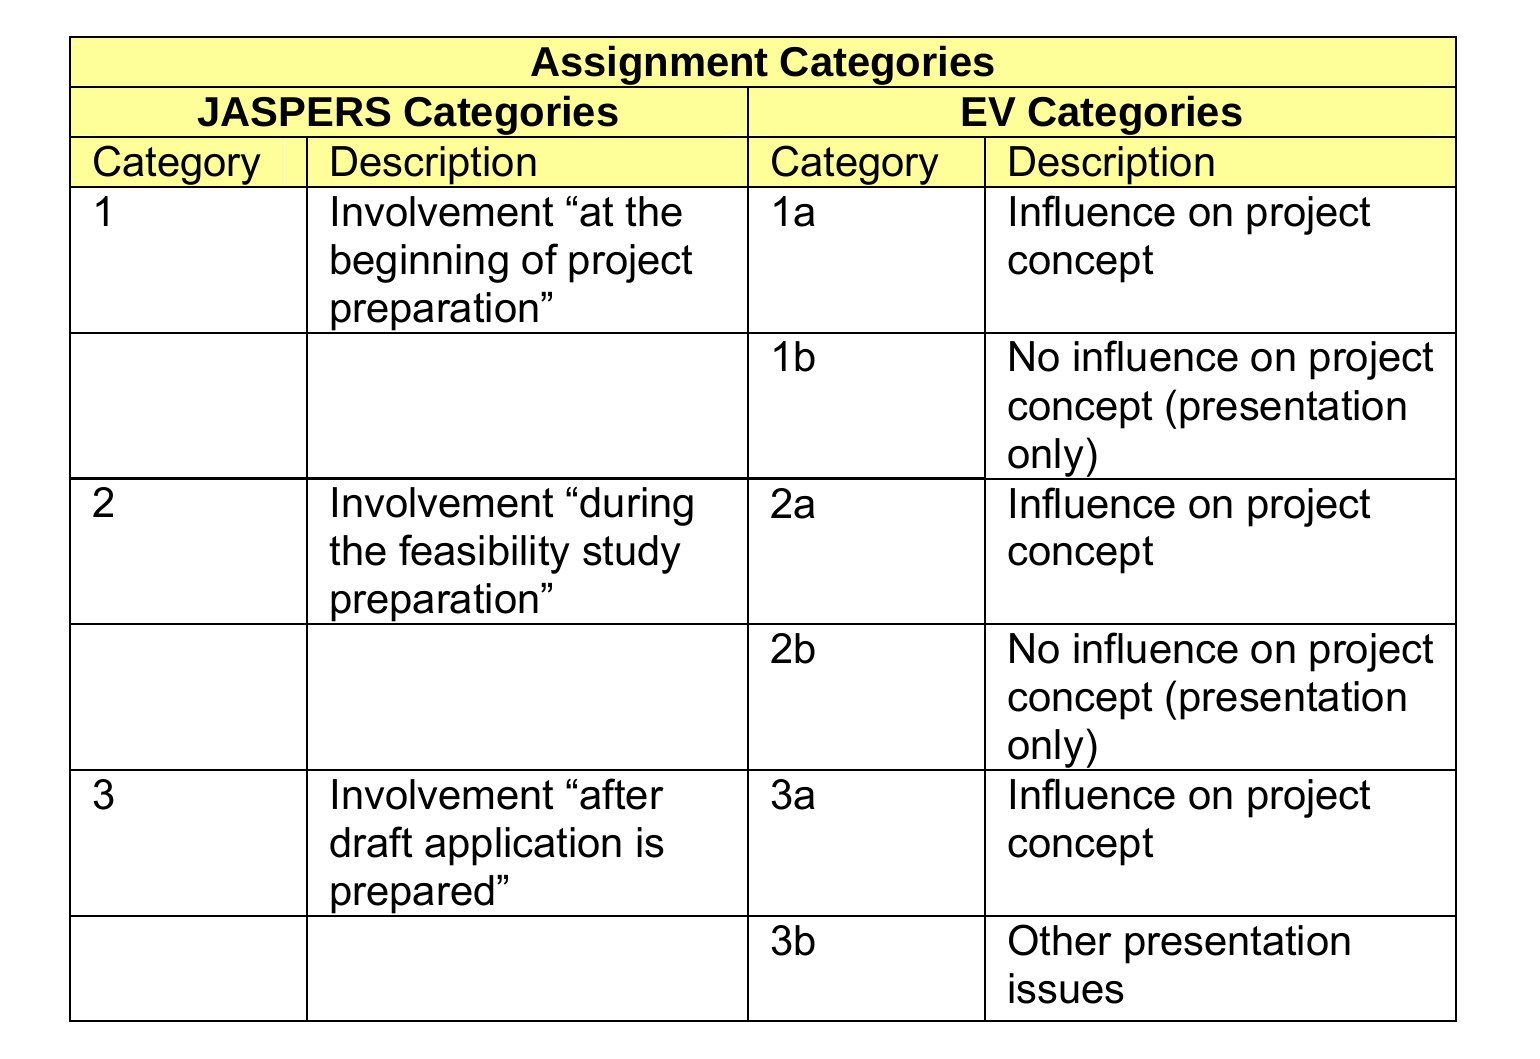

In [ ]:
# Function to crop tables with dynamic padding based on box dimensions
def crop_table_with_dynamic_padding(image, box, padding_ratio=0.05):
    x_min, y_min, x_max, y_max = [int(coord) for coord in box.xyxy[0].tolist()]
    width, height = x_max - x_min, y_max - y_min

    # Calculate padding as a percentage of the detected table dimensions
    padding_x = int(width * padding_ratio)
    padding_y = int(height * padding_ratio)

    # Apply padding with boundary checks
    x_min, y_min = max(0, x_min - padding_x), max(0, y_min - padding_y)
    x_max, y_max = min(image.width, x_max + padding_x), min(image.height, y_max + padding_y)

    # Crop the image
    return image.crop((x_min, y_min, x_max, y_max))

# Crop detected tables based on dynamic padding
cropped_tables = []
for i, box in enumerate(yolo_results[0].boxes):
    cropped_table = crop_table_with_dynamic_padding(img, box)
    cropped_tables.append(cropped_table)
    print(f"Displaying cropped table {i + 1}")
    display(cropped_table)


In [ ]:
# Initialise the Table Transformer model for structure recognition
processor = DetrImageProcessor.from_pretrained("microsoft/table-transformer-structure-recognition")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Displaying table structure with enhanced bounding boxes and labels


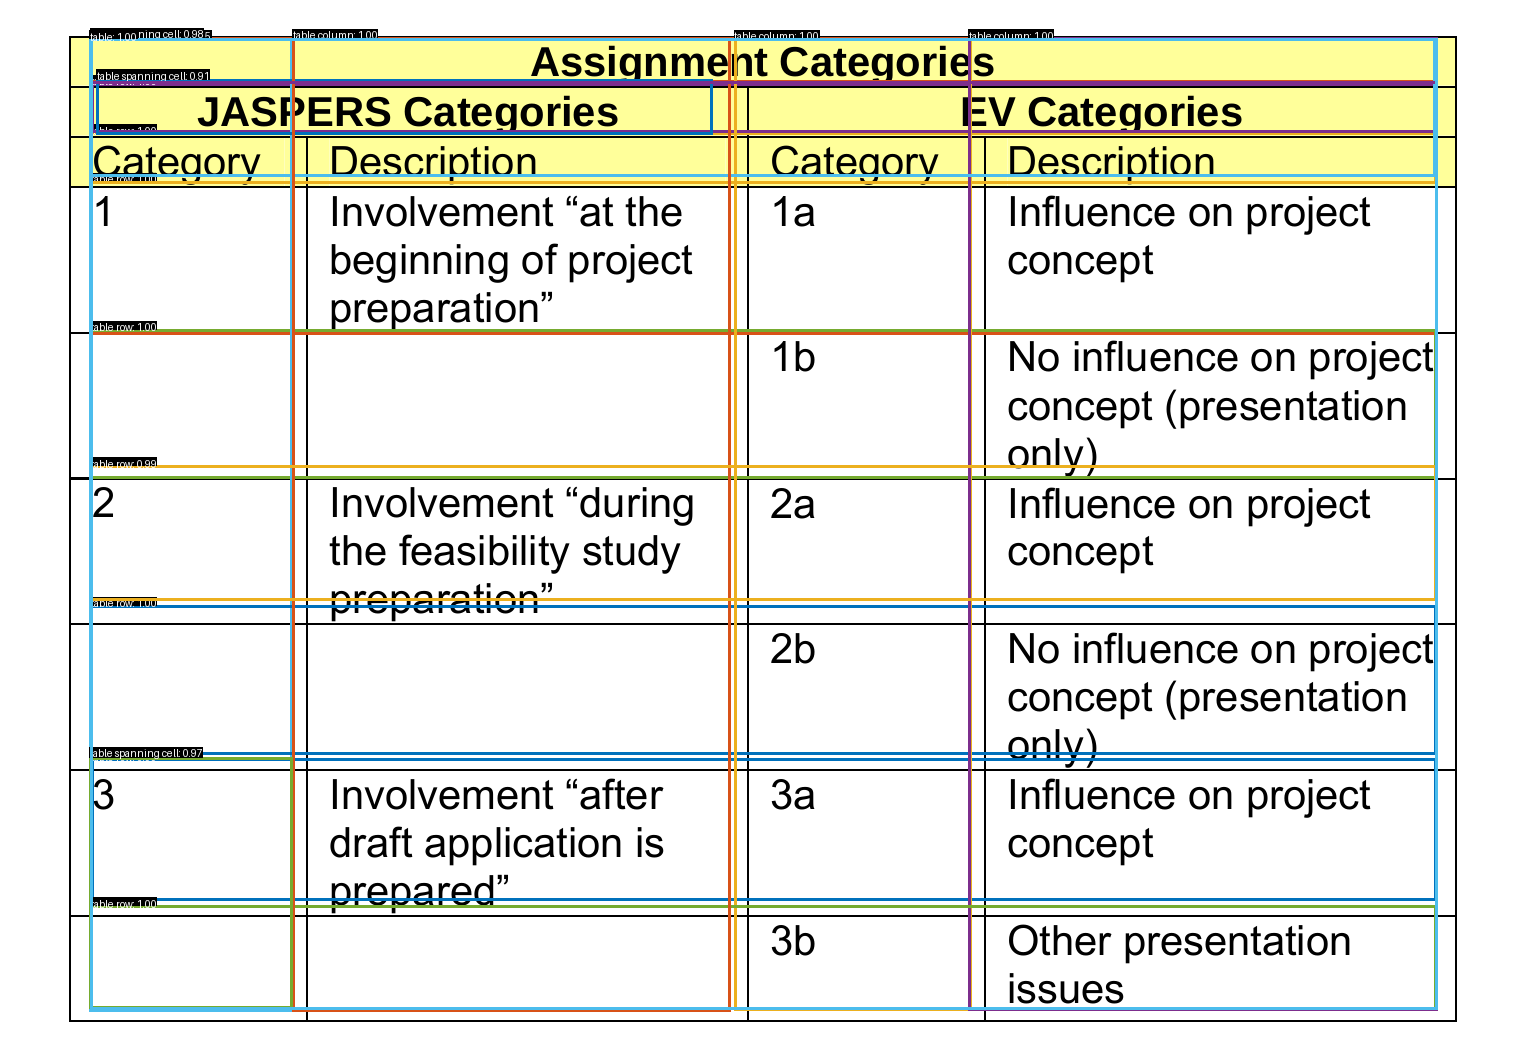

In [ ]:
# Perform structure recognition on each cropped table and render results
for i, cropped_table in enumerate(cropped_tables):
    encoding = processor(images=cropped_table, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding)

    # Post-process the output to get bounding boxes, labels, and scores
    target_sizes = [cropped_table.size[::-1]]
    results = processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]

    # Render detected table structure on the image
    scores, labels, boxes = results["scores"], results["labels"], results["boxes"]
    render_structure_on_image_with_labels(cropped_table, scores, labels, boxes)
